In [1]:
%load_ext watermark
%watermark

2019-05-15T20:26:30+02:00

CPython 3.6.5
IPython 6.4.0

compiler   : GCC 7.2.0
system     : Linux
release    : 5.0.13-arch1-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


# Analisis exploratorio de Datos

## Ingesta y procesado inicial

En esta sección vamos a hacer un ejemplo completo de como hacer un Análisis Exploratorio de Datos (EDA en inglés).

Hoy en dia no hay un proceso standard a la hora de realizar EDA, pero un proceso que a mi me gusta está basado en el proceso propuesto por Distric Data Labs ([aquí](http://blog.districtdatalabs.com/data-exploration-with-python-1) un blog post, y [aquí](https://www.youtube.com/watch?v=YEBRkLo568Q) una charla sobre el proceso).

El archivo original está en: https://www.fueleconomy.gov/feg/epadata/vehicles.csv.zip
El archivo que vamos a usar es una versión modificada (con menos columnas)

Descripcion del dataset
http://www.fueleconomy.gov/feg/ws/index.shtml#ft7


Supongamos que somos la agencia de porteccion ambiental americana, la EPA. Uno de sus trabajos es analizar los coches nuevos que se venden en EEUU y estudiar su contaminacion.

In [2]:
import pandas as pd

In [3]:
%matplotlib notebook

### Lectura de datos


In [6]:
vehiculos = pd.read_csv("data/vehiculos-original.csv")

In [7]:
vehiculos.shape

(38436, 11)

In [8]:
vehiculos.head()

,make,model,year,displ,cylinders,trany,drive,VClass,fuelType,comb08,co2TailpipeGpm
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
1,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
3,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500


Es conveniente renombrar las columnas y darles un nombre descriptivo

In [9]:
vehiculos = vehiculos.rename(columns={
    "cylinders":"cilindros",
    "trany":"transmision",
    "make":"fabricante",
    "model":"modelo",
    "displ":"desplazamiento", #volumen de desplazamiento del motor
    "drive":"traccion",
    "VClass":"clase",
    "fuelType":"combustible",
    "comb08":"consumo", #combined MPG for fuelType1
    "co2TailpipeGpm":"co2", # tailpipe CO2 in grams/mile
})

In [10]:
vehiculos.head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
1,AM General,DJ Po Vehicle 2WD,1984,2.5,4.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,17,522.764706
2,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
3,AM General,FJ8c Post Office,1984,4.2,6.0,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,13,683.615385
4,AM General,Post Office DJ5 2WD,1985,2.5,4.0,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,16,555.437500


In [11]:
vehiculos.dtypes

fabricante         object
modelo             object
year                int64
desplazamiento    float64
cilindros         float64
transmision        object
traccion           object
clase              object
combustible        object
consumo             int64
co2               float64
dtype: object

**¿Cual es el objetivo de este análisis?**

Un aspecto importante que me gusta siempre tener claro al empezar un EDA es saber el objetivo del mismo. Generalmente hay una lista de preguntas concretas que responder, o al menos las personas a cargo de recolectar el dataset lo crearon con un objetivo en mente.

En este caso, uno de los objetivos por los cuales la EPA crea este dataset es para controlar lo que contamina cada coche, en este caso la variable co2

### Descripción de la entidad.
- fabricante
- fabricante-modelo
- fabricante-model-año
- fabricante-año

### Despues de cada paso es importante guardar el dataset. Asi no modificamos el original



In [13]:
vehiculos.to_csv("data/vehiculos.1.procesado_inicial.csv", index=False)

# Diagnostico de calidad de los datos (QA)

matplotlib notebook, es muy util para hacer plots mas visibles, pero es un poco complicada de usar ya que requiere el cerrar cada plot para poder continuar.

Alternativamente, se puede usar %matplotlib inline, que es más sencilla ya que simplemente muestra el gráfico original en el jupyter notebook. Para modificar el tamaño de los plots en este caso basta con cambiar el parámetro general de matplotlib figure.figsize al tamaño de gráfico deseado (en pulgadas)


In [14]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,12) # 10 pulgadas de ancho y 10 de alto para todos los plots

En este apartado vamos a revisar el dataset. El objetivo sera tener un dataset lo mas parecido al original pero sin fallos en el mismo que puedan llevarnos a sacar conclusiones erroneas.

El input de este paso es el output del anterior

In [16]:
vehiculos = pd.read_csv("data/vehiculos.1.procesado_inicial.csv")

In [17]:
vehiculos.shape

(38436, 11)

### Duplicados

En este apartado se intentan ver dos cosas:

* Asegurarse de que datos que no debieran estar duplicados no lo están (por ejemplo, numeros de telefono)

* Revisar  si hay columnas que tengan un alto numero de duplicados, ya que pueden no aportar mucha informacion

Recordemos que las entidades posibles eran:   
    
    fabricante
    fabricante-modelo
    fabricante-modelo-año
    fabricante-año

De estas entidades, las unicas que no se deberian repetir coches especificos, es decir, fabricante+modelo +año

In [18]:
vehiculos['modelo_unico'] = vehiculos.fabricante.str.cat([vehiculos.modelo, vehiculos.year.apply(str)],sep='-')

In [19]:
vehiculos.modelo_unico.value_counts()

Jeep-Cherokee/Wagoneer-1985               24
Ford-F150 Pickup 2WD-1984                 19
Chevrolet-C10 Pickup 2WD-1984             19
GMC-C15 Pickup 2WD-1984                   19
Chevrolet-C10 Pickup 2WD-1985             18
Chevrolet-S10 Pickup 2WD-1984             18
GMC-C15 Pickup 2WD-1985                   18
GMC-S15 Pickup 2WD-1984                   18
Chevrolet-C10 Pickup 2WD-1986             17
Ford-Ranger Pickup 2WD-1984               17
Mitsubishi-Truck 2WD-1984                 17
Dodge-Ram 50 Pickup 2WD-1984              17
GMC-C15 Pickup 2WD-1986                   17
Mercury-Lynx-1984                         16
Volkswagen-Rabbit-1984                    16
GMC-Vandura G15/25 2WD-1984               16
Ford-Escort-1984                          16
Ford-F150 Pickup 2WD-1985                 16
Ford-Escort-1985                          16
Chevrolet-G10/20 Van 2WD-1984             16
Ford-F150 Pickup 4WD-1984                 15
Ford-Bronco 4WD-1984                      15
Ford-E150 

Nos damos cuenta de que hay muchos repetidos, veamos un ejemplo

In [20]:
vehiculos[vehiculos.modelo_unico=='Chevrolet-C1500 Pickup 2WD-1991'].head()

,fabricante,modelo,year,desplazamiento,cilindros,transmision,traccion,clase,combustible,consumo,co2,modelo_unico
4957,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Automatic 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4958,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4959,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 5-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4960,Chevrolet,C1500 Pickup 2WD,1991,4.3,6.0,Manual 5-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,17,522.764706,Chevrolet-C1500 Pickup 2WD-1991
4961,Chevrolet,C1500 Pickup 2WD,1991,5.0,8.0,Automatic 4-spd,Rear-Wheel Drive,Standard Pickup Trucks,Regular,15,592.466667,Chevrolet-C1500 Pickup 2WD-1991


Como vemos , cada modelo unico tiene diferentes configuraciones de cada coche (3 velocidades o 4 por ejemplo)
Por lo tanto, solo vamos a considerar duplicados aquellos records que sean idénticos en todas sus columnas

In [21]:
vehiculos[vehiculos.duplicated()].shape

(1506, 12)

Vemos que hay 1506 records duplicados, podemos eliminarlos para el resto del análisis ya que pueden distorsionar las conclusiones

In [22]:
vehiculos = vehiculos.drop_duplicates()
vehiculos.shape

(36930, 12)

Borramos la columna `modelo_unico`

In [23]:
del vehiculos['modelo_unico']

Ahora falta ver si hay variables en las que haya una gran cantidad de registros que tengan el mismo valor (cardinalidad).

In [24]:
n_records = len(vehiculos)
def valores_duplicados_col(df):
    for columna in df:
        n_por_valor = df[columna].value_counts()
        mas_comun = n_por_valor.iloc[0]
        menos_comun = n_por_valor.iloc[-1]
        print("{} | {}-{} | {}".format(
            df[columna].name,
            round(mas_comun / (1.0*n_records),3),
            round(menos_comun / (1.0*n_records),3),
            df[columna].dtype
        ))

valores_duplicados_col(vehiculos)

fabricante | 0.1-0.0 | object
modelo | 0.005-0.0 | object
year | 0.038-0.007 | int64
desplazamiento | 0.095-0.0 | float64
cilindros | 0.38-0.0 | float64
transmision | 0.287-0.0 | object
traccion | 0.353-0.005 | object
clase | 0.145-0.0 | object
combustible | 0.652-0.0 | object
consumo | 0.097-0.0 | int64
co2 | 0.084-0.0 | float64


Vemos que los campos `traccion, transmission, cilindros y combustible` pueden tener un problema de valores repetidos, en realidad 30% no es algo muy dramatico, seria distinto si el valor mas comun tuviera un 90%.

In [25]:
vehiculos.traccion.value_counts(normalize=True)

Front-Wheel Drive             0.360280
Rear-Wheel Drive              0.352863
4-Wheel or All-Wheel Drive    0.177345
All-Wheel Drive               0.062325
4-Wheel Drive                 0.030886
2-Wheel Drive                 0.011402
Part-time 4-Wheel Drive       0.004899
Name: traccion, dtype: float64

Vemos que esto tiene sentido, ya que la inmensa mayoria de vehiculos tienen traccion a dos ruedas, sean delanteras o traseras. 

En este caso alguien con conocimiento de dominio podria darse cuenta de que probablemente 2-Wheel Drive sea simplemente una clasificacion distinta de Front o Rear. 

https://www.edmunds.com/car-technology/what-wheel-drive.html

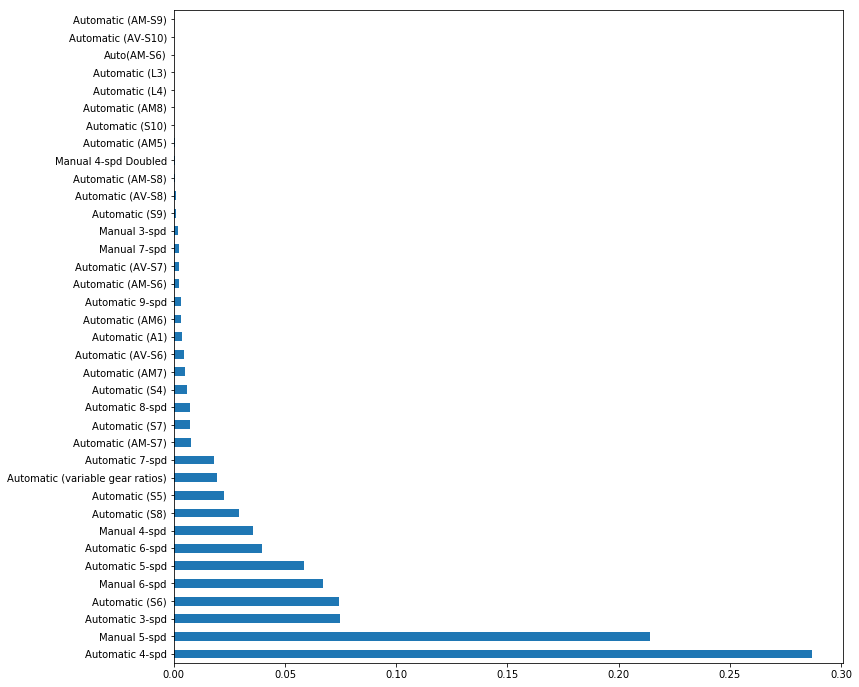

In [26]:
vehiculos.transmision.value_counts(normalize=True).plot.barh();

Vemos que aunque transmisión tenga una cardinalidad relativamente alta, en realidad muestra una distribución de tipos, con dos clases mayoritarias

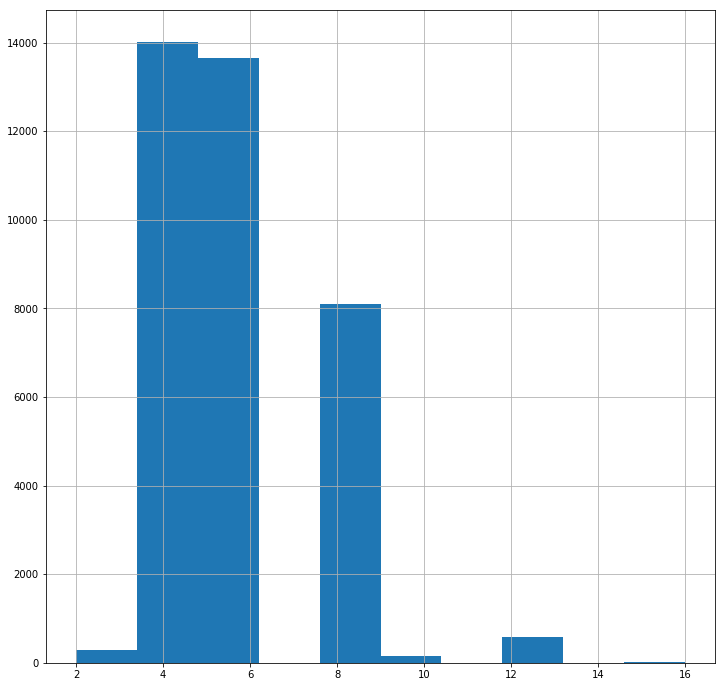

In [27]:
vehiculos.cilindros.hist();

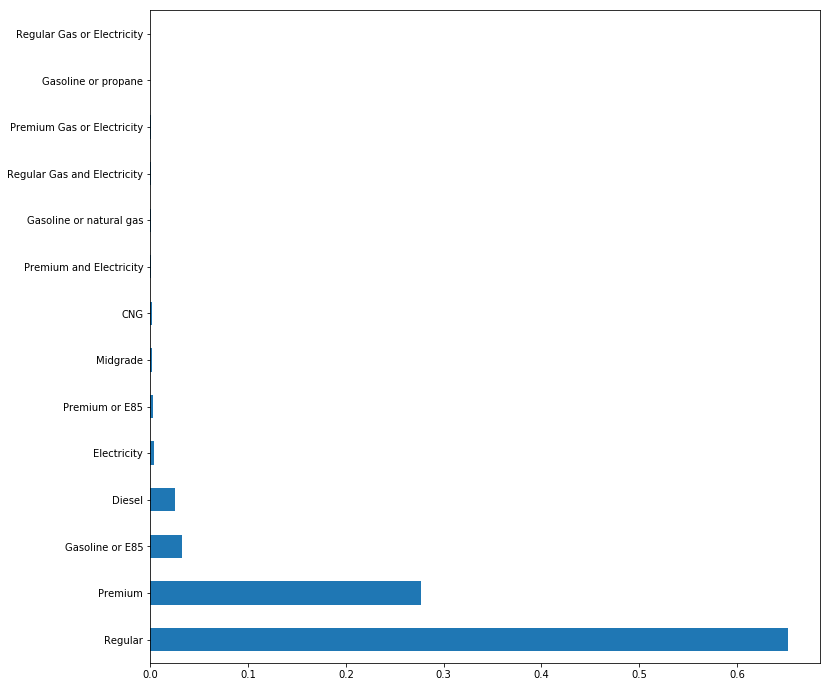

In [28]:
vehiculos.combustible.value_counts(normalize=True).plot.barh();

Vemos que la columna `combustible` si puede tener un problema al tener el 65% de los casos gasolina `Regular`

### Valores inexistentes

In [29]:
n_records = len(vehiculos)
def valores_inexistentes_col(df):
    for columna in df:
        print("{} | {} | {}".format(
            df[columna].name, len(df[df[columna].isnull()]) / (1.0*n_records), df[columna].dtype
        ))

valores_inexistentes_col(vehiculos)

fabricante | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 0.0037909558624424585 | float64
cilindros | 0.003845112374763065 | float64
transmision | 0.00029786081776333605 | object
traccion | 0.02158137015976171 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


Vemos que campo `traccion, cilindros y transmision` tienen valores inexistentes. Sin embargo son cantidades despreciables (maximo es la variable traccion con un 3% inexistente)



### Valores extremos (Outliers)
Para detectar valores extremos una medida general es considerar outliers aquellos valores con una puntuación Z (z score) mayor de 3, esto es, que se alejan 3 veces o mas desviaciones standard de la media.

El z score se define como:

$$z(x)= \frac{x-\mu}{\sigma}$$

In [30]:
from scipy import stats
import numpy as np

def outliers_col(df):
    for columna in df:
        if df[columna].dtype != np.object:
            n_outliers = len(df[np.abs(stats.zscore(df[columna])) > 3])    
            print("{} | {} | {}".format(
                df[columna].name,
                n_outliers,
                df[columna].dtype
        ))

outliers_col(vehiculos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 233 | int64
co2 | 358 | float64


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Vemos que las variables de consumo y co2 tienen outliers. Podemos hacer un boxplot para visualizar esto mejor

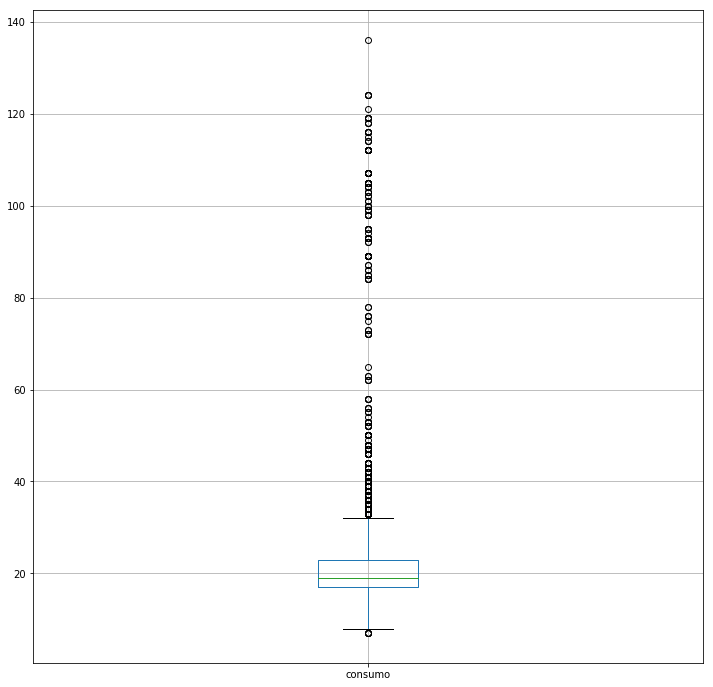

In [31]:
vehiculos.boxplot(column='consumo');

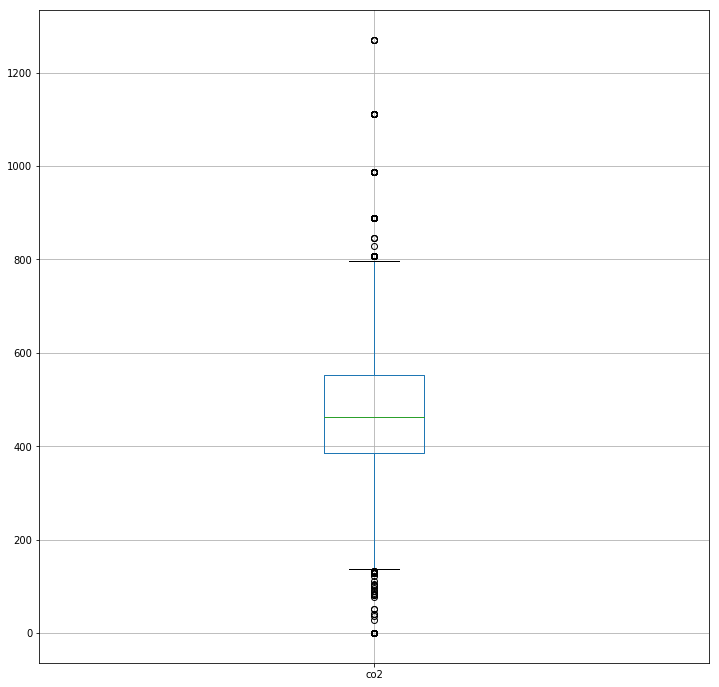

In [32]:
vehiculos.boxplot(column='co2');

Vemos que en cuanto a consumo hay algunos coches que contaminan mas de lo normal y otros que contaminan menos de lo normal, tambien vemos que hay coches que no contaminan nada!

Es posible que haya coches que no usen gasolina en el dataset?

In [33]:
vehiculos[vehiculos.co2==0].combustible.unique()

array(['Electricity'], dtype=object)

In [34]:
vehiculos.combustible.unique()

array(['Regular', 'Premium', 'Diesel', 'Premium and Electricity',
       'Premium or E85', 'Electricity', 'Premium Gas or Electricity',
       'Gasoline or E85', 'Gasoline or natural gas', 'CNG',
       'Regular Gas or Electricity', 'Midgrade',
       'Regular Gas and Electricity', 'Gasoline or propane'], dtype=object)

Vemos que en este dataset hay vehiculos hibridos y vehiculos electricos puros. Dado que el objetivo es la contaminacion, convendria remover al menos aquellos vehiculos que no contaminan

In [35]:
vehiculos_no_electricos = vehiculos[vehiculos.co2>0]

Ya que hemos descubierto esto, volvamos a revisar los datos con el nuevo dataset

In [36]:
outliers_col(vehiculos_no_electricos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 400 | int64
co2 | 221 | float64


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Vemos que siguen habiendo outliers en cuanto a consumo y co2. ¿Será por que los vehículos híbridos consumen menos? Si fuera por esto estos valores extremos son valores perfectamente válidos y por tanto no deberíamos eliminarlos

In [37]:
vehiculos_no_electricos[
    np.abs(stats.zscore(vehiculos_no_electricos["consumo"])) > 3
].combustible.value_counts(normalize=True)

Regular                        0.7175
Diesel                         0.1525
Premium                        0.0550
Regular Gas and Electricity    0.0475
Premium Gas or Electricity     0.0200
Regular Gas or Electricity     0.0050
Premium and Electricity        0.0025
Name: combustible, dtype: float64

Vemos que no es el caso, que hay outliers en un rango de combustibles tanto híbridos como no híbridos. Asi que son outliers reales.

In [38]:
valores_duplicados_col(vehiculos_no_electricos)

fabricante | 0.099-0.0 | object
modelo | 0.005-0.0 | object
year | 0.038-0.007 | int64
desplazamiento | 0.095-0.0 | float64
cilindros | 0.38-0.0 | float64
transmision | 0.287-0.0 | object
traccion | 0.351-0.005 | object
clase | 0.145-0.0 | object
combustible | 0.652-0.0 | object
consumo | 0.097-0.0 | int64
co2 | 0.084-0.0 | float64


### Valores inexistentes

In [39]:
valores_inexistentes_col(vehiculos)

fabricante | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 0.0037909558624424585 | float64
cilindros | 0.003845112374763065 | float64
transmision | 0.00029786081776333605 | object
traccion | 0.02158137015976171 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


Ahora vemos que no hay valores inexistentes extremos en ninguna variable. La variable con mayor numero de valores inexistentes es traccion (2%). Obviamente, los coches electricos no tienen motor de gasolina y por tanto, no tienen cilindros.

### Conclusion
- Hay 1506 records duplicados (los hemos removido)
- las variables `desplazamiento, cilindros, transmision y traccion tienen valores inexistentes`
- La variable `combustible` tiene una clase dominante (65% de coches tienen combustible `Regular`)
- hay un outlier en las variables `co2` y `consumo`
- Hay coches hibridos y coches electricos (hemos removido estos ultimos ya que no contaminan).

### Exportamos el trabajo